# Electron thermal conductivity from PIC simulations

In [1]:
include("data_loading.jl")

make_phase_space_plots (generic function with 1 method)

The electron axial heat flux is defined as

$$ Q_{e,x} = -\kappa_{e,x} \frac{\partial T_e}{\partial x}.$$

The conductivity thus is given by

$$
\kappa_{e,x} = Q_{e,x} \left[\frac{\partial T_e}{\partial x}\right]^{-1}.
$$

So, if we can compute the axial heat flux $Q_{e,x}$ and the axial electron temperature gradient, $\partial T_e/\partial x$, we should be able to compute the electron thermal conductivity.

## Temperature gradient

As a first step, we compute the electron axial temperature gradient. Since our simulations only have grid points in the radial direction, we first need to bin particles by their axial location. We can then compute the temperature in each bin, before computing the gradient. Let's first load some data to analyze. We'll first analyze the case where the density is $n_0 = 10^{17} \; \text{m}^{-3}$.

In [2]:
data = load_all_data("noisy_axial_1.0_7.5e+17_100_100");

We can then extract the electron properties and the axial simulation length. To start, we'll just pick an arbitrary iteration to extract. Later, we will need to do this at each saved timestep in order to see how the temperature gradient evolves over time.

In [3]:
# get electron properties from loaded data at chosen iteration
iter = 100
electron_data = data.particles.electrons
m_e = electron_data.mass
q_e = abs(electron_data.charge)
n_e = electron_data.density
position = electron_data.position[:, :, iter]
velocity = electron_data.velocity[:, :, iter]
num_particles = data.Ne

# get minimum and maximum particle position, rounded to nice values
xmin, xmax = round_bounds(extrema(position)...)

# get minimum and maximum particle velocity, rounded to nice values
vmin, vmax = round_bounds(extrema(velocity)...)

# compute axial simulation length
L_axial = xmax - xmin;

We first  bin particles by their x-positions.

In [4]:
# sort particles by position
perm = sortperm(position[:, 1])
pos_sorted = position[perm, :]
vel_sorted = velocity[perm, :]

# set up position bins
num_bins = round(Int, sqrt(num_particles))
bin_edges = LinRange(xmin, xmax, num_bins + 1)
bin_centers = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in 1:num_bins]

# NOTE: the following could be done in one pass much more quickly
# Assign particles to bins
bin_assignments = [searchsortedfirst(bin_edges, x) - 1 for x in @views pos_sorted[:, 1]]

# invert bin assignments to get particles indices as function
bin_ranges = [searchsortedfirst(bin_assignments, i) : searchsortedlast(bin_assignments, i) for i in 1:num_bins];

We then need to compute the electon temperature. The temperature is the variance if the velocity distribution function:

$$T_{e,x} = \frac{m_e}{q_e} \text{var}\left[f(v_x)\right] \; \text{[eV]}$$

The temperature can be anisotropic, so in general we might need to consider the axial (x), azimuthal (y) and radial (z) temperatures. Here, we will consider the axial temperature only.

In [5]:
using Statistics: var
temperatures = [m_e / q_e * var(vel_sorted[r, 1]) for r in bin_ranges];

We can now plot the temperatures to see what we're working with.

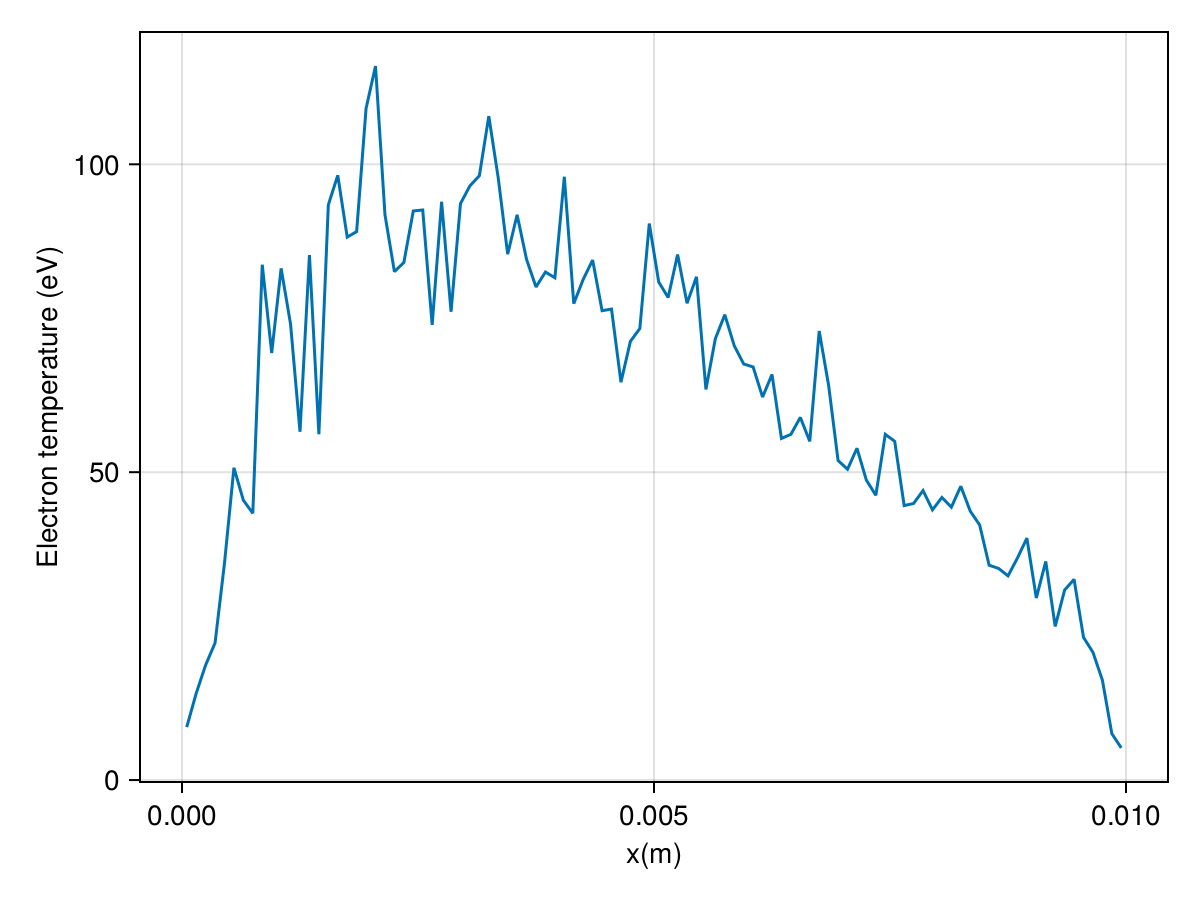

In [6]:
using CairoMakie

f = Figure()
ax = Axis(f[1,1], xlabel = "x(m)", ylabel = "Electron temperature (eV)")
lines!(ax, bin_centers, temperatures)
f

Remember that electrons move against the electric field (so in the negative x direction). It looks like we have linear heating until the left end of the domain, when the electrons rapidly cool down. This seems suspiciously like a boundary effect. To investigate this, we can plot the electron phase space.

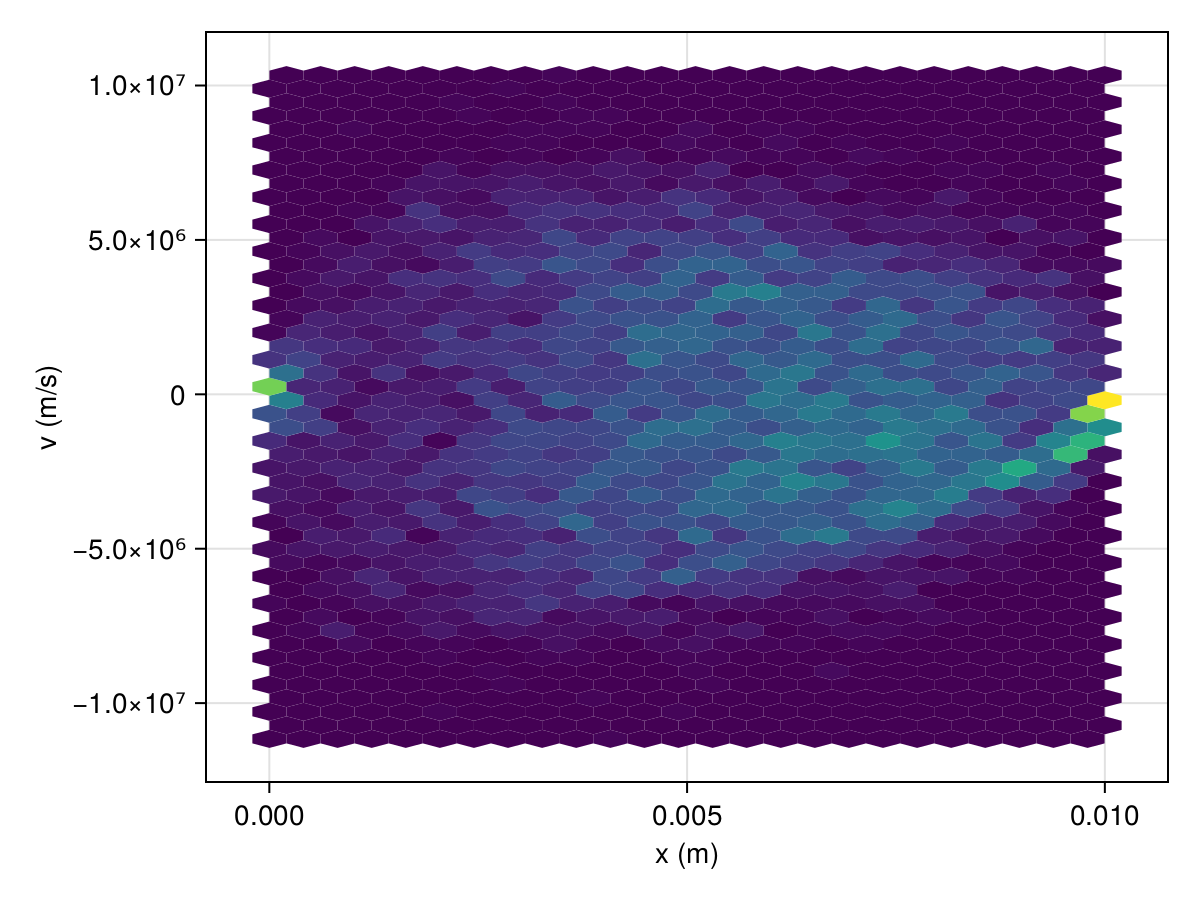

In [7]:
f, ax, h = hexbin(position[:, 1], velocity[:, 1], threshold = 0, bins = num_bins ÷ 2)
ax.xlabel = "x (m)"
ax.ylabel = "v (m/s)"
f

As suspected, it looks like the electrons heat pretty uniformly until reaching the left edge of the domain. This is an artifact of the virtual axial length. When particles hit the left boundary, they are emitted with randomized velocitys drawn from a one-sided Maxwellian vdf with temperature of 2 eV on the right boundary. Slower particles may thus be able to cross back over the right side of the domain before they can be accelerated away from it. This produces a population of slow electrons on the left side of the domain. This suggests that if we're interested in the instability-induced heating, we would be justified in cuttting off the right side of the domain. Let's pick a window of about 0.5 $L_{axial}$. We can then try fitting a line to that section of the temperature curve. The code below does a linear regression on its input data, and returns fit coefficients (with uncertainty) as well as the prediction error.

In [8]:
using Measurements

function fit_line(x, y)
    # fit line
    N = length(x)
    M = hcat(ones(N), x)
    b, m = M \ y

    # compute prediction error
    pred = @. m * x + b # Prediction
    var_pred = sum((pred[i] - y[i])^2 for i in eachindex(y)) / (N - 2)
    var_x = var(x)
    std_m = sqrt(var_pred / ((N - 1) * var_x))  # error in m
    sumsq = sum(_x^2 for _x in x) / N
    std_b = std_m * sqrt(sumsq) # error in b
    std_pred = sqrt(var_pred)   # prediction error
    return m ± std_m, b ± std_b, pred, std_pred
end

fit_line (generic function with 1 method)

In [9]:
const window_size = 0.6
const window_center = 0.6
window_left_index = clamp(round(Int, (window_center - window_size / 2) * num_bins), 1, num_bins)
window_right_index = clamp(round(Int, (window_center + window_size / 2) * num_bins), 1, num_bins)
window_range = window_left_index:window_right_index
x_left = bin_edges[window_left_index]
x_right = bin_edges[window_right_index+1]

# compute linear fit coefficients
x_window = bin_centers[window_range]
temp_window = temperatures[window_range]
m, b, σ = fit_line(x_window, temp_window);

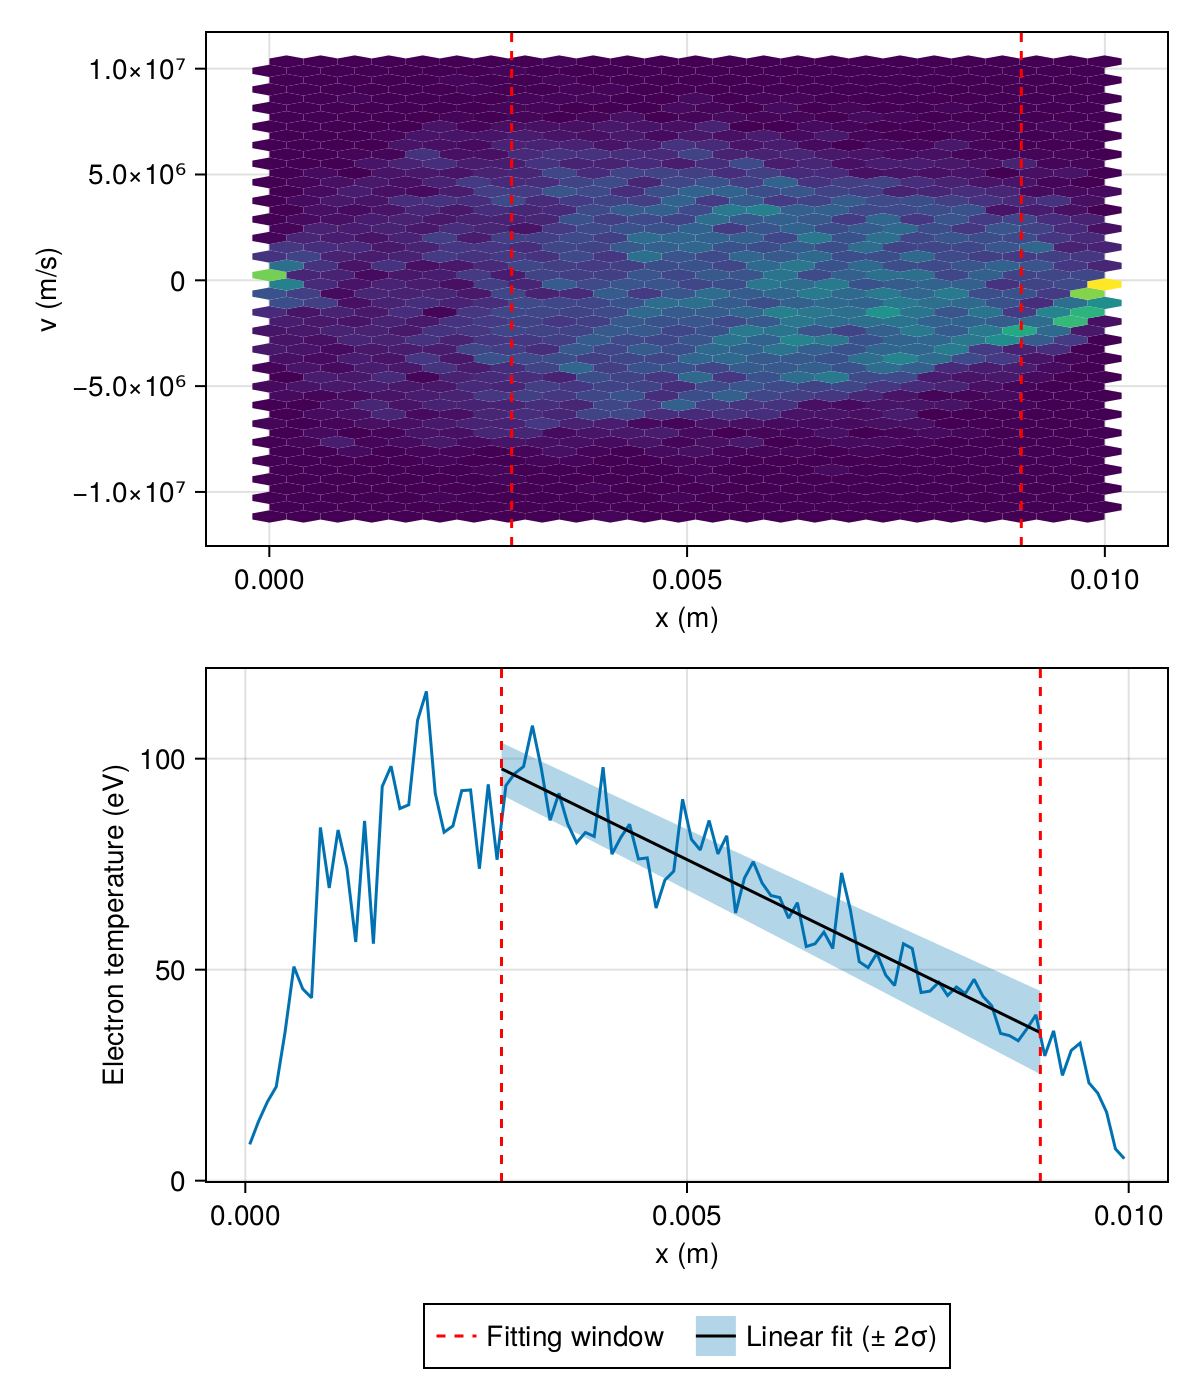

In [10]:
# Plot things
f = Figure(size = (600, 700))
ax_vdf = Axis(f[1,1], xlabel = "x (m)", ylabel = "v (m/s)")
ax_temp = Axis(f[2,1], xlabel = "x (m)", ylabel = "Electron temperature (eV)")

x_line = LinRange(x_left, x_right, 30)
y_line = @. m * x_line + b
y_σ = Measurements.uncertainty.(y_line)
y_line = Measurements.value.(y_line)
lower = @. y_line - 2 * y_σ
upper = @. y_line + 2 * y_σ

colors = Makie.wong_colors()

bnd = band!(ax_temp, x_line, lower, upper; color = (colors[1], 0.3))
lines!(ax_temp, bin_centers, temperatures)
l = lines!(ax_temp, x_line, y_line, color = :black)
limits = vlines!(ax_temp, [x_left, x_right], color = :red, linestyle = :dash)

h = hexbin!(ax_vdf, position[:, 1], velocity[:, 1], threshold = 0, bins = num_bins ÷ 2)
vlines!(ax_vdf, [x_left, x_right], color = :red, linestyle = :dash)

Legend(f[3, 1], [limits, [bnd, l]], ["Fitting window", "Linear fit (± 2σ)"], orientation = :horizontal)
f

Our linear fit looks pretty reasonable. We can take the fitted slope (m) as the temperature gradient for this iteration. Let's make a function to do all of this, and check that our results make sense for other iterations.

In [11]:
function temperature_gradient(data, iter; plot = false)
    # get electron properties from loaded data at chosen iteration
    electron_data = data.particles.electrons
    m_e = electron_data.mass
    q_e = abs(electron_data.charge)
    position = electron_data.position[:, :, iter]
    velocity = electron_data.velocity[:, :, iter]
    num_particles = data.Ne

    # get minimum and maximum particle position, rounded to nice values
    xmin, xmax = round_bounds(extrema(position)...)

    # sort particles by position
    perm = sortperm(position[:, 1])
    pos_sorted = position[perm, :]
    vel_sorted = velocity[perm, :]

    # set up position bins
    num_bins = round(Int, sqrt(num_particles))
    bin_edges = LinRange(xmin, xmax, num_bins + 1)
    bin_centers = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in 1:num_bins]

    # NOTE: the following could be done in one pass much more quickly
    # Assign particles to bins
    bin_assignments = [searchsortedfirst(bin_edges, x) - 1 for x in @views pos_sorted[:, 1]]

    # invert bin assignments to get particles indices as function
    bin_ranges = [searchsortedfirst(bin_assignments, i) : searchsortedlast(bin_assignments, i) for i in 1:num_bins];

    # compute temperatures
    temperatures = [m_e / q_e * var(vel_sorted[r, 1]) for r in bin_ranges];

    # Window setup
    window_left_index = clamp(round(Int, (window_center - window_size / 2) * num_bins), 1, num_bins)
    window_right_index = clamp(round(Int, (window_center + window_size / 2) * num_bins), 1, num_bins)
    window_range = window_left_index:window_right_index
    x_left = bin_edges[window_left_index]
    x_right = bin_edges[window_right_index+1]

    # compute linear fit coefficients
    x_window = bin_centers[window_range]
    temp_window = temperatures[window_range]
    m, b, σ = fit_line(x_window, temp_window);

    if (plot)
        # Plot things
        f = Figure(size = (600, 700))
        ax_vdf = Axis(f[1,1], xlabel = "x (m)", ylabel = "v (m/s)")
        ax_temp = Axis(f[2,1], xlabel = "x (m)", ylabel = "Electron temperature (eV)")

        x_line = LinRange(x_left, x_right, 30)
        y_line = @. m * x_line + b
        y_σ = Measurements.uncertainty.(y_line)
        y_line = Measurements.value.(y_line)
        lower = @. y_line - 2 * y_σ
        upper = @. y_line + 2 * y_σ

        colors = Makie.wong_colors()

        bnd = band!(ax_temp, x_line, lower, upper; color = (colors[1], 0.3))
        lines!(ax_temp, bin_centers, temperatures)
        l = lines!(ax_temp, x_line, y_line, color = :black)
        limits = vlines!(ax_temp, [x_left, x_right], color = :red, linestyle = :dash)

        h = hexbin!(ax_vdf, position[:, 1], velocity[:, 1], threshold = 0, bins = num_bins ÷ 2)
        vlines!(ax_vdf, [x_left, x_right], color = :red, linestyle = :dash)

        Legend(f[3, 1], [limits, [bnd, l]], ["Fitting window", "Linear fit (± 2σ)"], orientation = :horizontal)
        display(f)
    end
    return m
end

temperature_gradient (generic function with 1 method)

### Iteration = 50

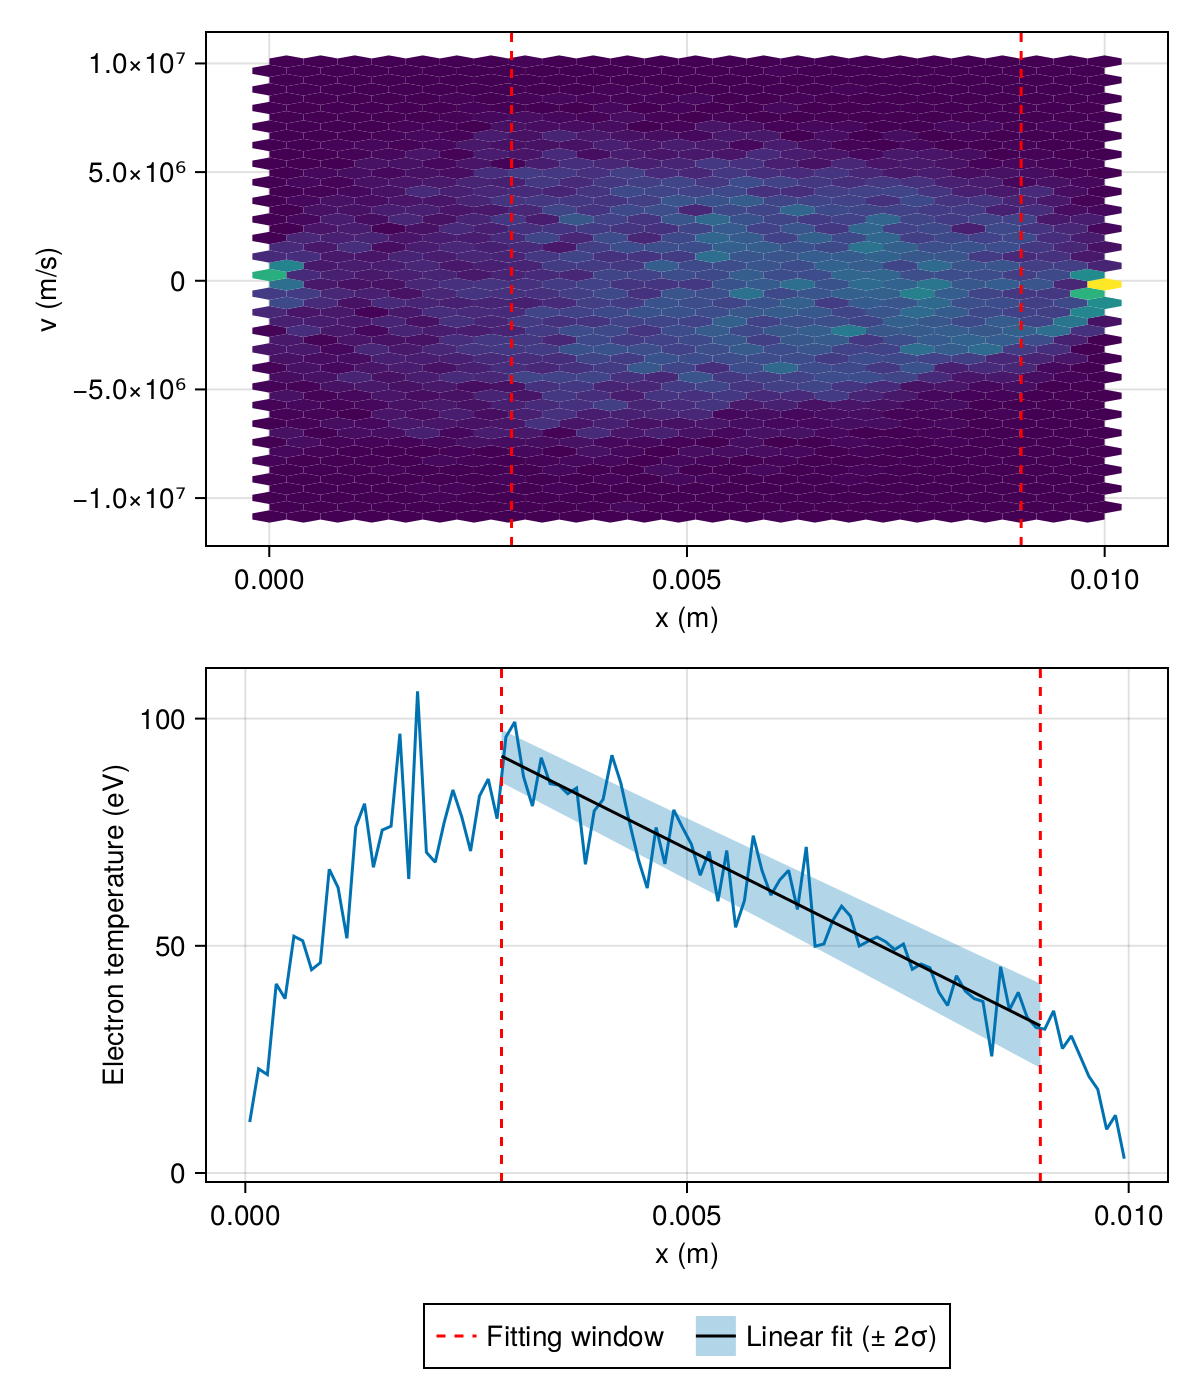

-9730.0 ± 420.0

In [12]:
temperature_gradient(data, 50, plot = true)

### Iteration = 200

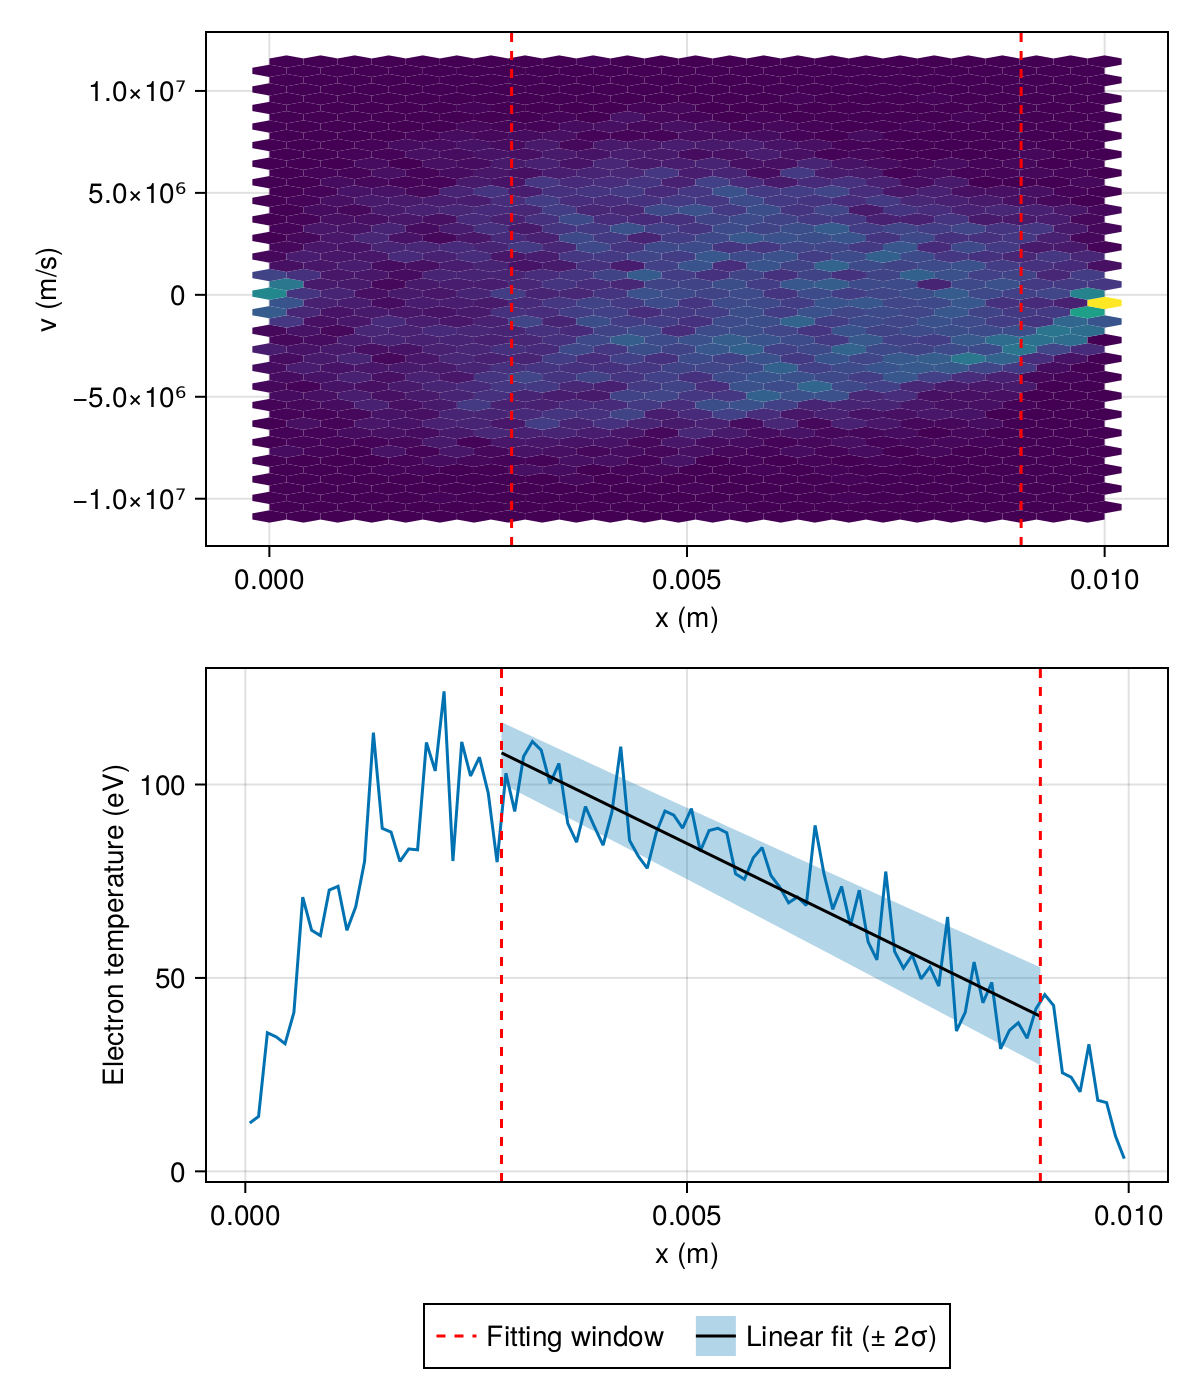

-11160.0 ± 580.0

In [13]:
temperature_gradient(data, 200, plot = true)

It seems like the code is pretty robust. We can now compute the temperature gradient at each iteration as well as the mean temperature gradient at steady state

In [14]:
∇T = [temperature_gradient(data, iter) for iter in eachindex(data.iter)];
∇T_val = Measurements.value.(∇T) ./ 1000
∇T_err = Measurements.uncertainty.(∇T) ./ 1000;

In [15]:
using Random

function monte_carlo_mean(xs, σs; num_trials = 100)
    N = length(xs)
    rand_buffer = zeros(N)
    means = zeros(num_trials)
    stds = zeros(num_trials)

    for i in eachindex(means)
        randn!(rand_buffer)

        @. rand_buffer = rand_buffer * σs + xs
        means[i] = mean(rand_buffer)
        stds[i] = stdm(rand_buffer, means[i]) / sqrt(N)
    end

    μ = mean(means)
    σ = mean(stds)
    return μ ± σ
end

monte_carlo_mean (generic function with 1 method)

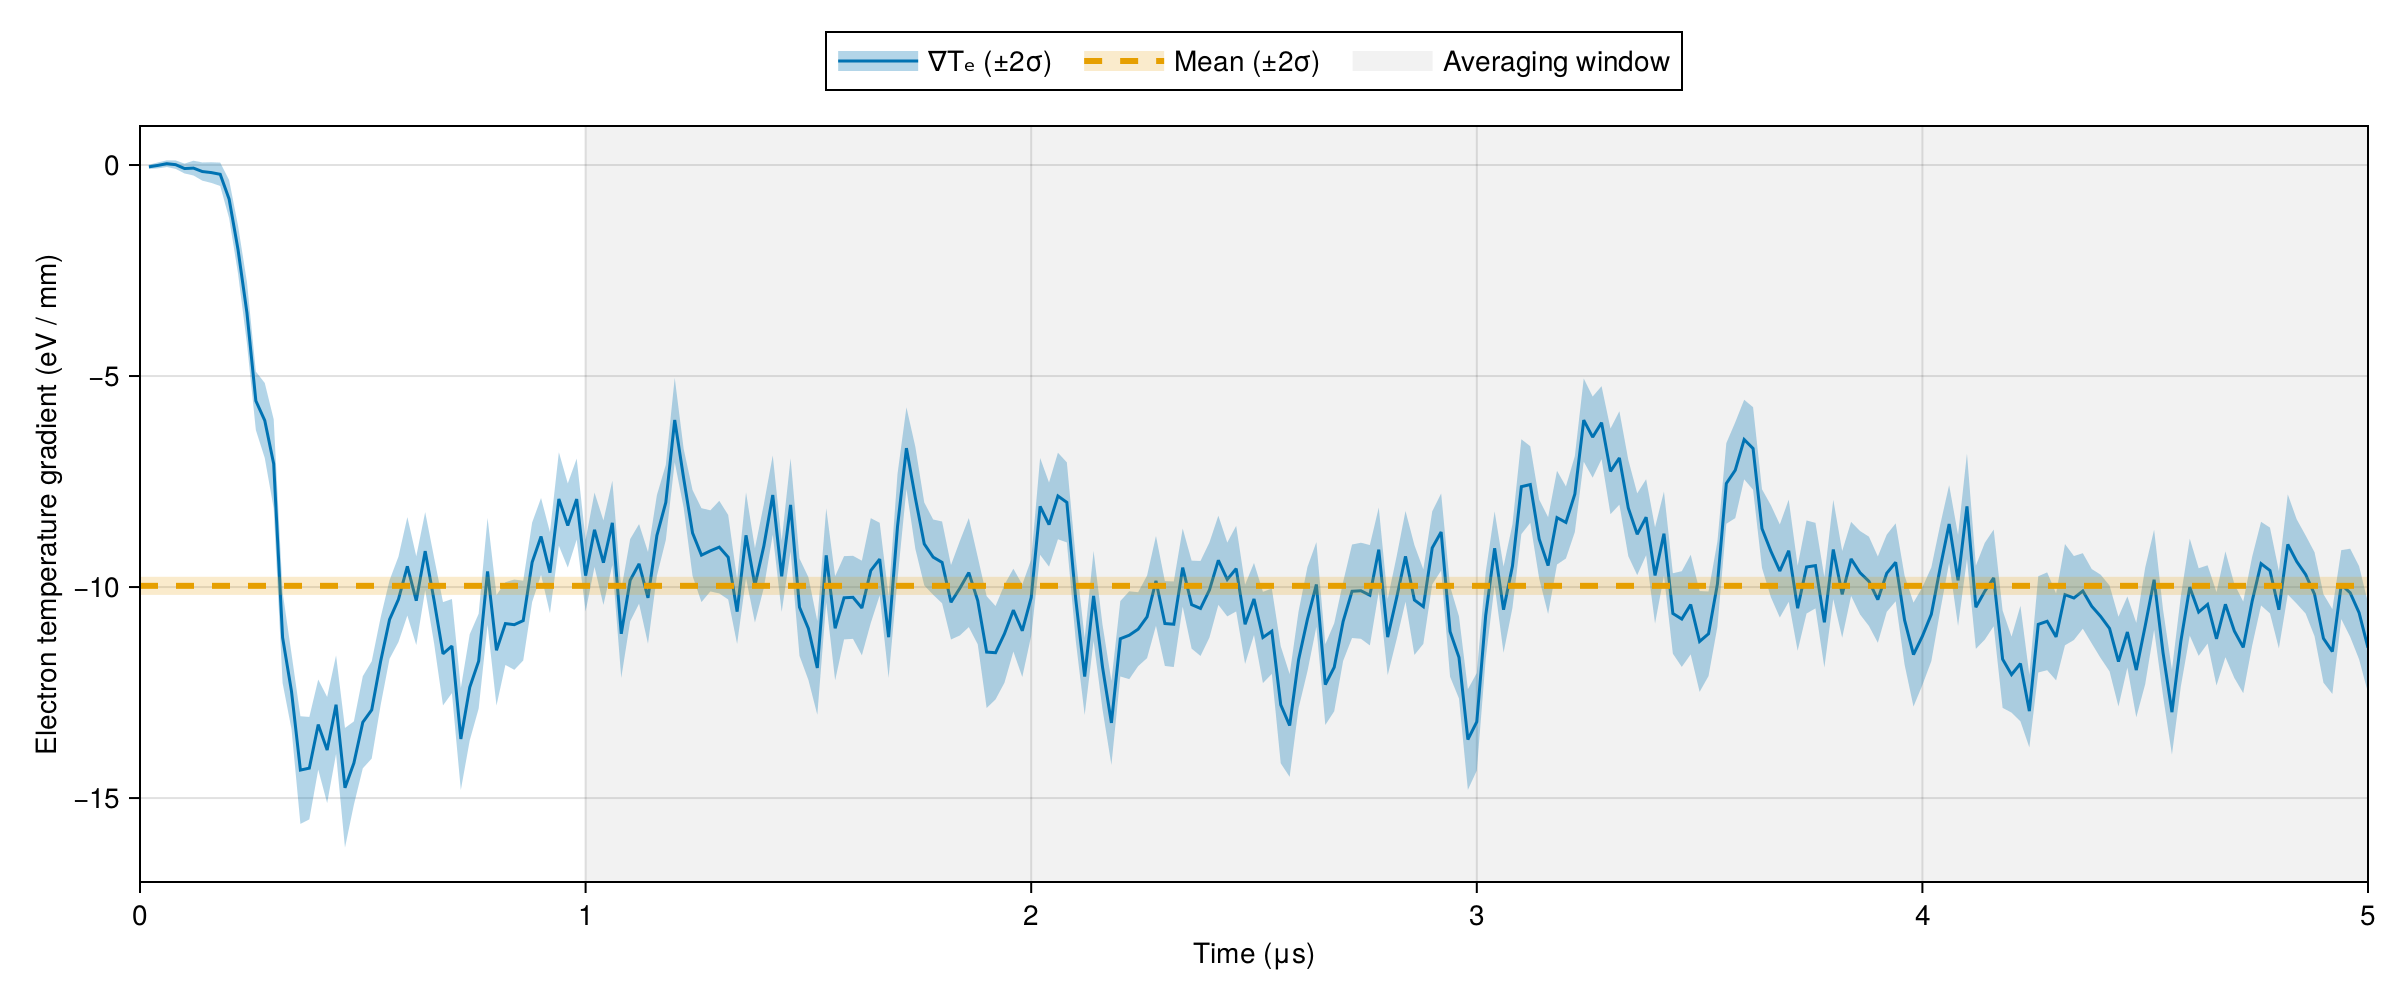

In [16]:
f = Figure(size = (1200, 500))
time = data.time * 1e6
xlims = round_bounds(extrema(time)...)
xticks = xlims[1]:xlims[end]
xlims = (xticks[1], xticks[end])
ax = Axis(f[1,1], xlabel = "Time (μs)", ylabel = "Electron temperature gradient (eV / mm)", )
xlims!(ax, xlims)

# Compute and plot averaging window
mean_window_μs = [1, 5]
mean_first_ind = findfirst(>=(mean_window_μs[1]), time)
mean_last_ind = findlast(<=(mean_window_μs[end]), time)
p_window = vspan!(ax, mean_window_μs[1], mean_window_μs[2], color = (:grey, 0.1))

# Plot data
lower = @. ∇T_val - 2 * ∇T_err
upper = @. ∇T_val + 2 * ∇T_err
colors = Makie.wong_colors()
p_data_b = band!(ax, time, lower, upper, color = (colors[1], 0.3))
p_data_l = lines!(ax, time, ∇T_val)

# Compute and plot mean
∇T_mean = monte_carlo_mean(∇T_val[mean_first_ind:end], ∇T_err[mean_first_ind:end], num_trials = 100)

p_mean_b = hspan!(ax, ∇T_mean.val - 2 * ∇T_mean.err, ∇T_mean.val + 2 * ∇T_mean.err; color = (colors[2], 0.2))
p_mean_l = hlines!(ax, [∇T_mean.val]; linewidth = 3, linestyle = :dash, color = colors[2])

Legend(f[0, 1], [[p_data_b, p_data_l], [p_mean_b, p_mean_l], p_window], ["∇Tₑ (±2σ)", "Mean (±2σ)", "Averaging window"], orientation = :horizontal, patchsize = (40, 10))
f

## Heat flux

With the temperature gradient computed, we can now compute the heat flux, the second piece of the puzzle. The axial heat flux is a property of the electron distribution function, and is defined as

$$
Q_x =  \int \frac{1}{2} m_e |\mathbf{v} - \langle \mathbf{v} \rangle|^2 v_x  f(\mathbf{v}) d^3 v.
$$

To avoid boundary effects, we will consider only particles lying within the same axial extent as we employed for our electron temperature gradient calculations. We can then compute a Monte carlo estimate of our integral as

$$
Q_x \approx \frac{m_e}{2} \sum_p |\mathbf{v}_p- \langle \mathbf{v} \rangle|^2 v_{x,p},
$$

where $p$ are the particles in our region of interest.

In [17]:
function heat_flux(data, iter; plot = false)
    # get electron properties from loaded data at chosen iteration
    electron_data = data.particles.electrons
    m_e = electron_data.mass
    q_e = abs(electron_data.charge)
    position = electron_data.position[:, :, iter]
    velocity = electron_data.velocity[:, :, iter]
    num_particles = data.Ne

    # get minimum and maximum particle position, rounded to nice values
    xmin, xmax = round_bounds(extrema(position)...)
    dx = xmax - xmin

    # sort particles by position
    perm = sortperm(position[:, 1])
    pos_sorted = position[perm, :]
    vel_sorted = velocity[perm, :]

    # Window setup
    window_center_x = window_center * dx + xmin
    window_left_x = window_center_x - window_size / 2 * dx
    window_right_x = window_center_x + window_size / 2 * dx

    window_left_index = @views searchsortedfirst(pos_sorted[:, 1], window_left_x)
    window_right_index = @views searchsortedlast(pos_sorted[:, 1], window_right_x)

    # Compute heat flux in W / m²
    vx, Q, T = heat_flux_from_velocities(vel_sorted[window_left_index:window_right_index, :], m_e, plot)
    return vx, Q, T
end

heat_flux (generic function with 1 method)

In [18]:
using StatsBase
include("multi_gaussian.jl")

function heat_flux_from_velocities(v, m, plot = false)
    N = size(v, 1)
    mean_vel = mapslices(mean, v, dims = 1)

    vx_diff = v[:, 1] .- mean_vel[1]
    vy_diff = v[:, 2] .- mean_vel[2]
    vz_diff = v[:, 3] .- mean_vel[3]

    integrand = @. (vx_diff^2 + vy_diff^2 + vz_diff^2) * vx_diff

    Q = 0.5 * m * mean(integrand)

    T = m * varm(vx_diff, 0.0)

    if (plot)
        f, ax, h = hist(vx_diff, bins = round(Int, sqrt(N)), normalization = :pdf)
        μs, σs = fit_multi_gaussian(vx_diff ./ 1e7, 2)
        xs = LinRange(-1e7, 1e7, 100)
        ys = multi_gaussian_pdf(xs, [μs; σs] .* 1e7)
        lines!(ax, xs, ys, color = Makie.wong_colors()[2], linewidth = 3)
        @show μs, σs
        display(f)
    end
    return mean_vel[1], T, Q
end

heat_flux_from_velocities (generic function with 2 methods)

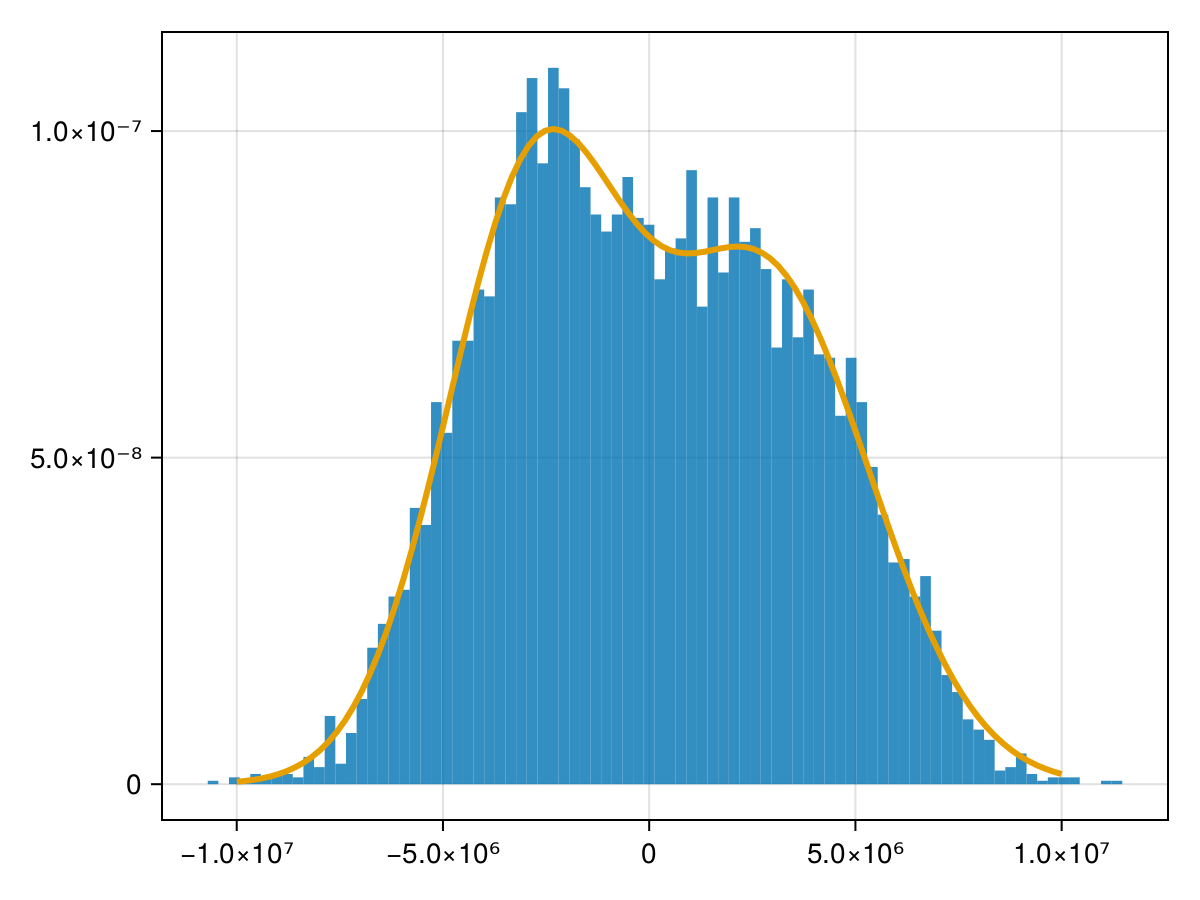

(μs, σs) = ([-0.2759862832310017, 0.280678748205664], [0.2179005240241668, 0.25710384452848])

(-333054.3971924134, 1.1960405661839104e-17, 4.5668404739989025e-12)

In [19]:
heat_flux(data, 110, plot = true)

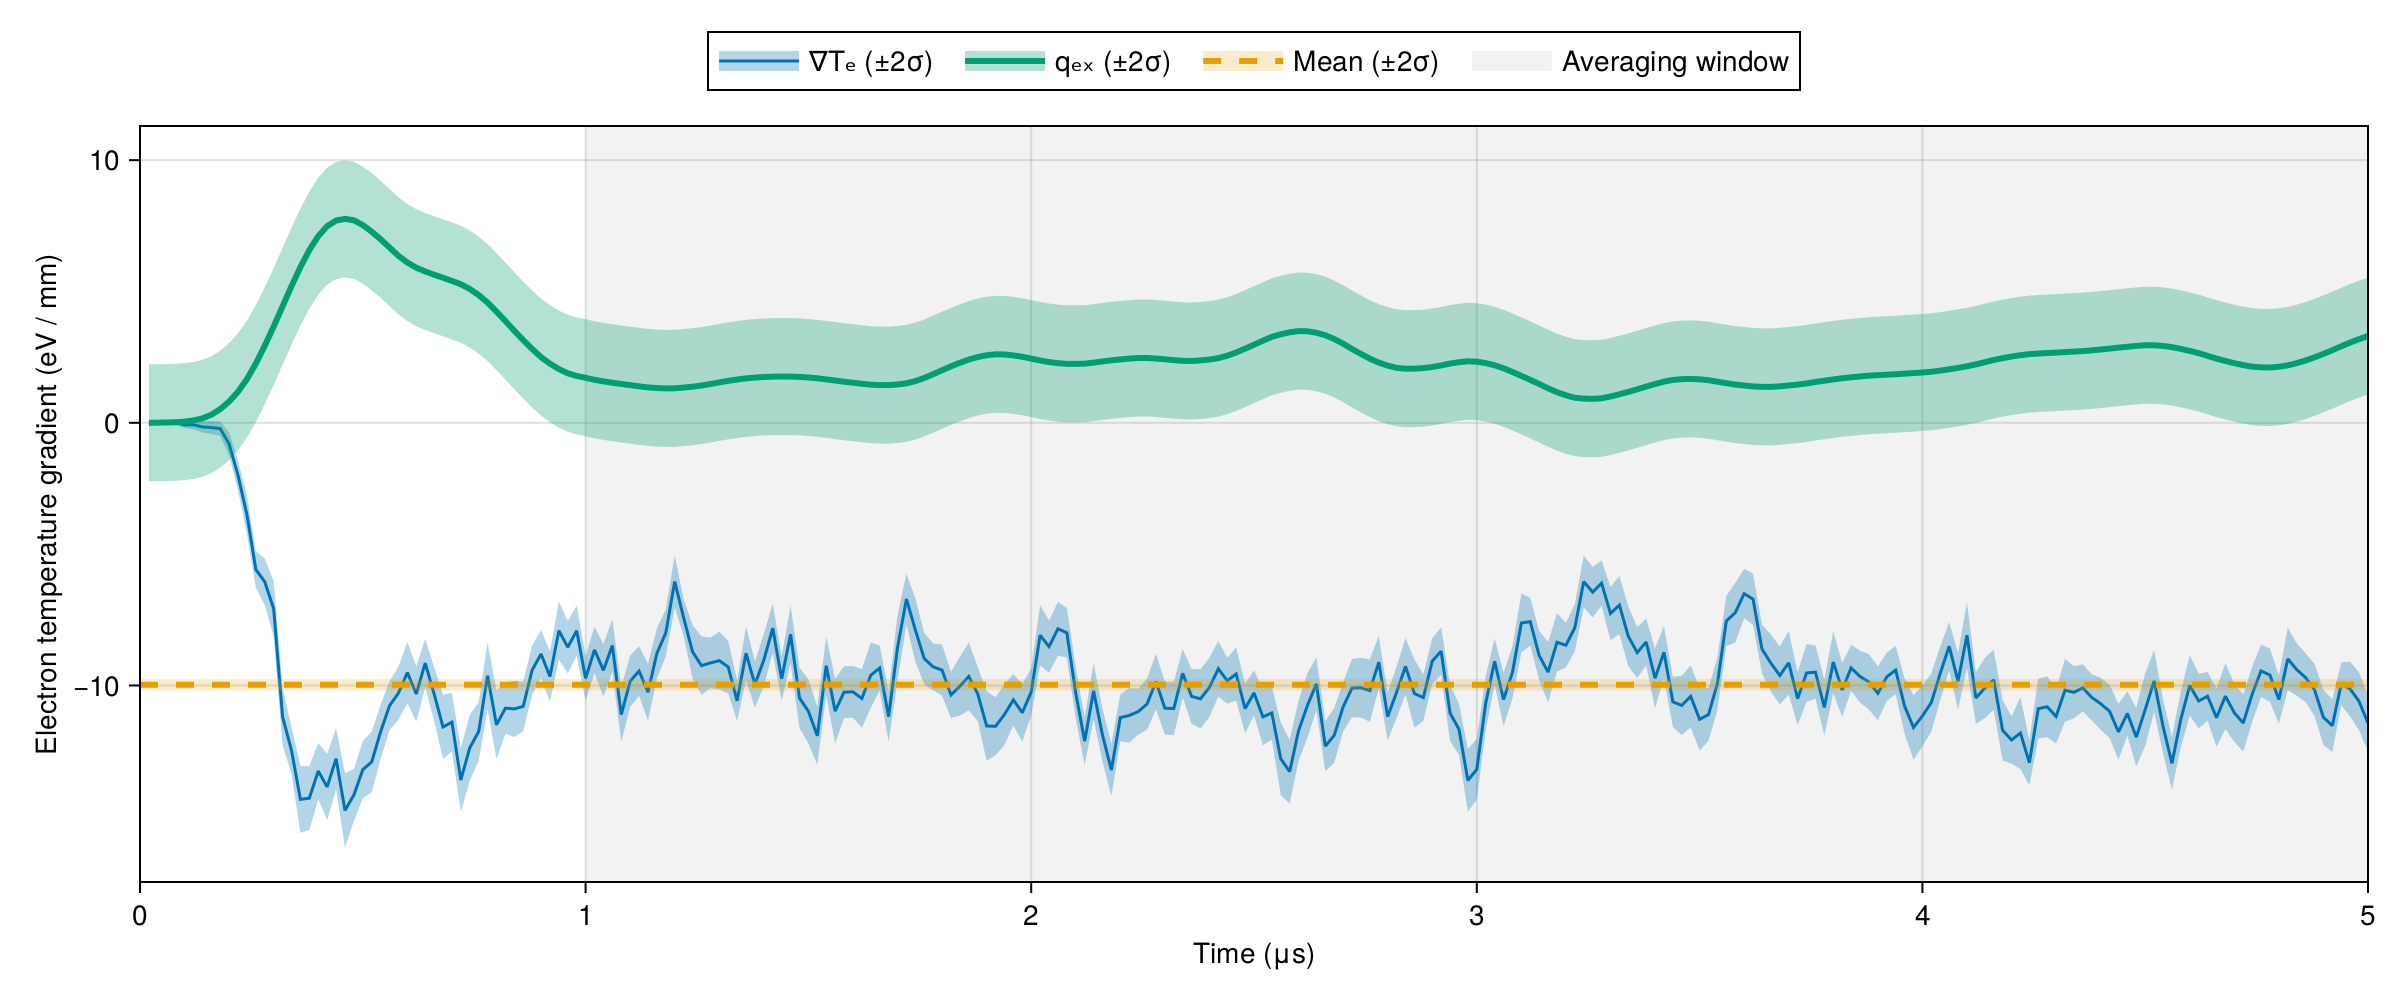

In [20]:
using ImageFiltering

results = [heat_flux(data, iter) for iter in eachindex(data.iter)]
vx = [res[1]  for res in results]
T = [res[2] for res in results]
q = [res[3] for res in results] * n_e # W / m²

q_scaled = @. q / 1e6 # W / mm^2

f = Figure(size = (1200, 500))
time = data.time * 1e6
xlims = round_bounds(extrema(time)...)
xticks = xlims[1]:xlims[end]
xlims = (xticks[1], xticks[end])
ax = Axis(f[1,1], xlabel = "Time (μs)", ylabel = "Electron temperature gradient (eV / mm)", )
xlims!(ax, xlims)

# Compute and plot averaging window
mean_window_μs = [1, 5]
mean_first_ind = findfirst(>=(mean_window_μs[1]), time)
mean_last_ind = findlast(<=(mean_window_μs[end]), time)
p_window = vspan!(ax, mean_window_μs[1], mean_window_μs[2], color = (:grey, 0.1))

# Plot data
lower = @. ∇T_val - 2 * ∇T_err
upper = @. ∇T_val + 2 * ∇T_err
colors = Makie.wong_colors()
p_data_b = band!(ax, time, lower, upper, color = (colors[1], 0.3))
p_data_l = lines!(ax, time, ∇T_val)

# Compute and plot mean
∇T_mean = monte_carlo_mean(∇T_val[mean_first_ind:end], ∇T_err[mean_first_ind:end], num_trials = 100)

p_mean_b = hspan!(ax, ∇T_mean.val - 2 * ∇T_mean.err, ∇T_mean.val + 2 * ∇T_mean.err; color = (colors[2], 0.2))
p_mean_l = hlines!(ax, [∇T_mean.val]; linewidth = 3, linestyle = :dash, color = colors[2])

# Plot heat flux
ker = ImageFiltering.Kernel.gaussian((5,))
q_filtered = imfilter(q_scaled, ker)
#p_q = lines!(ax, time, Q, color = (colors[3], 0.5))
q_err = std(q_scaled .- q_filtered)
b_q_filt = band!(ax, time, q_filtered .- 2 * q_err, q_filtered .+ 2 * q_err, color = (colors[3], 0.3))
p_q_filt = lines!(ax, time, q_filtered, linewidth = 3, color = colors[3])

Legend(f[0, 1], [[p_data_b, p_data_l], [p_q_filt, b_q_filt], [p_mean_b, p_mean_l], p_window], ["∇Tₑ (±2σ)", "qₑₓ (±2σ)", "Mean (±2σ)", "Averaging window"], orientation = :horizontal, patchsize = (40, 10))
f

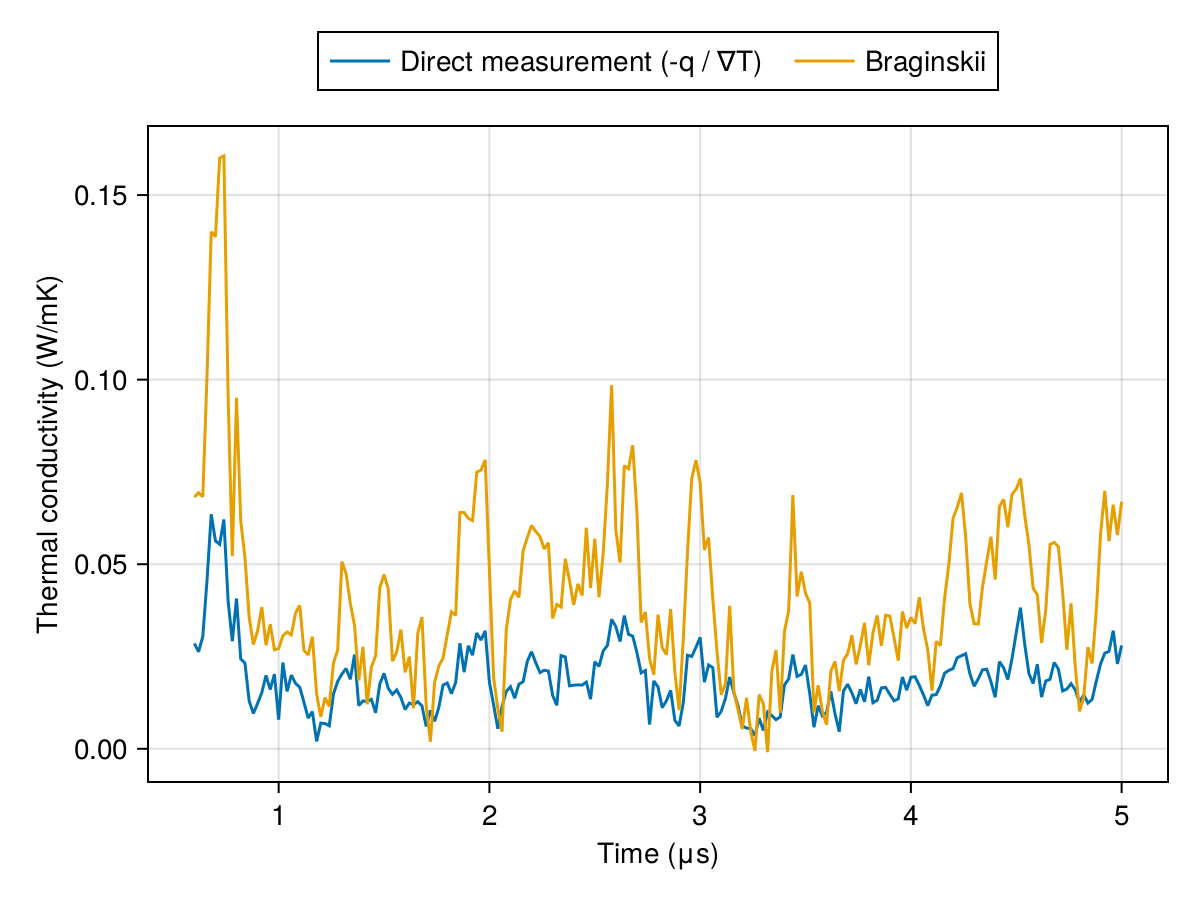

In [21]:
E0 = 20_000
μ = -vx / E0

start = 30
inds = start:length(μ)
N = length(inds)

# Temperature and gradient in K and K / m
∇T_K = @. q_e * ∇T / k_B

# conductivity in W / mK
κ_W_mK = Measurements.value.(@. -q / ∇T_K)

# braginskii conductivity in W / mK
κ_brag = @. 4.7 * μ * n_e * k_B * T / q_e

f, ax, l_k = lines(time[inds], κ_W_mK[inds])

l_μ = lines!(ax, time[inds], κ_brag[inds])

ax.xlabel = "Time (μs)"
ax.ylabel = "Thermal conductivity (W/mK)"
Legend(
    f[0,1],
    [l_k, l_μ],
    [
        "Direct measurement (-q / ∇T)",
        "Braginskii",
    ];
    orientation = :horizontal,
    patchsize = (30, 10)
)

save(joinpath(data.dir, "conductivity.png"), f, px_per_unit = 2)

μ_κ_brag = mean(κ_brag[inds])
σ_κ_brag = stdm(κ_brag[inds], μ_κ_brag) / sqrt(N)

μ_κ = mean(κ_W_mK[inds])
σ_κ = stdm(κ_W_mK[inds], μ_κ) / sqrt(N)

df = DataFrame("type" => ["direct", "braginskii"], "mean" => [μ_κ, μ_κ_brag], "std" => [σ_κ, σ_κ_brag])
CSV.write(joinpath(data.dir, "conductivity.csv"), df)

f

In [81]:
function analyze_sim(data; plot = false)
    # density
    n_e = data.particles.electrons.density

    # get temperature gradient
    ∇T = [temperature_gradient(data, iter).val for iter in eachindex(data.iter)]

    # get mean velocity, temperature, and heat flux
    results = [heat_flux(data, iter) for iter in eachindex(data.iter)]
    vx = [res[1]  for res in results]
    T = [res[2] for res in results]
    q = [res[3] for res in results] * n_e

    # compute mobility
    E0 = 20_000
    B0 = 0.02
    μ = -vx / E0

    # get time (average after 1μs)
    start_time = 1e-6
    start_ind = findfirst(>=(start_time), data.time)
    inds = start_ind:length(data.time)
    N = length(inds)

    # Temperature and gradient in K and K / m
    ∇T_K = @. q_e * ∇T / k_B

    # conductivity in W / mK
    κ_W_mK = @. -q / ∇T_K

    # braginskii conductivity in W / mK
    κ_brag = @. 4.7 * μ * n_e * k_B * T / q_e

    if (plot)
        f, ax, l_k = lines(time[inds], κ_W_mK[inds])

        l_μ = lines!(ax, time[inds], κ_brag[inds])

        ax.xlabel = "Time (μs)"
        ax.ylabel = "Thermal conductivity (W/mK)"
        Legend(
            f[0,1],
            [l_k, l_μ],
            [
                "Direct measurement (-q / ∇T)",
                "Braginskii",
            ];
            orientation = :horizontal,
            patchsize = (30, 10)
        )

        save(joinpath(data.dir, "conductivity.png"), f, px_per_unit = 2)

        display(f)
    end

    # Mean temperature in eV
    μ_T = mean(T[inds]) / q_e
    σ_T = stdm(T[inds] / q_e, μ_T) / sqrt(N)

    # Mean temperature gradient in eV/m
    μ_∇T = mean(∇T[inds])
    σ_∇T  = stdm(∇T[inds], μ_∇T) / sqrt(N)

    # Mean mobility in m^2/Vs
    μ_μ = mean(μ[inds])
    σ_μ = stdm(μ[inds], μ_μ)/ sqrt(N)

    # Mean conductivity (braginskii) in W/mK
    μ_κ_brag = mean(κ_brag[inds])
    σ_κ_brag = stdm(κ_brag[inds], μ_κ_brag) / sqrt(N)
    κ_brag = μ_κ_brag ± σ_κ_brag

    # Mean conductivity (direct) in W/mK
    μ_κ = mean(κ_W_mK[inds])
    σ_κ = stdm(κ_W_mK[inds], μ_κ) / sqrt(N)
    κ_direct = μ_κ ± σ_κ
    return (;n = n_e, E = E0, B = B0, κ_brag, κ_direct, μ = μ_μ ± σ_μ, T = μ_T ± σ_T, ∇T = μ_∇T ± σ_∇T)
end

analyze_sim (generic function with 1 method)

In [163]:
results = sort(
    [analyze_sim(load_all_data(dir)) for dir in readdir(DATA_DIR)],
    by = x -> x.n
)


11-element Vector{@NamedTuple{n::Float64, E::Int64, B::Float64, κ_brag::Measurement{Float64}, κ_direct::Measurement{Float64}, μ::Measurement{Float64}, T::Measurement{Float64}, ∇T::Measurement{Float64}}}:
 (n = 1.0e16, E = 20000, B = 0.02, κ_brag = 1.97e-5 ± 6.0e-6, κ_direct = 0.003 ± 0.0038, μ = 1.38 ± 0.42, T = 21.68 ± 0.16, ∇T = -226.0 ± 33.0)
 (n = 2.0e16, E = 20000, B = 0.02, κ_brag = 5.9e-5 ± 1.1e-5, κ_direct = 5.7e-5 ± 9.2e-5, μ = 1.36 ± 0.27, T = 34.9 ± 0.37, ∇T = -3440.0 ± 130.0)
 (n = 3.0e16, E = 20000, B = 0.02, κ_brag = 0.000111 ± 1.3e-5, κ_direct = 5.27e-5 ± 7.5e-6, μ = 1.19 ± 0.14, T = 47.78 ± 0.26, ∇T = -8420.0 ± 140.0)
 (n = 5.0e16, E = 20000, B = 0.02, κ_brag = 0.000359 ± 2.4e-5, κ_direct = 0.000123 ± 9.1e-6, μ = 2.1 ± 0.14, T = 52.44 ± 0.29, ∇T = -11610.0 ± 150.0)
 (n = 7.5e16, E = 20000, B = 0.02, κ_brag = 0.00139 ± 8.3e-5, κ_direct = 0.000512 ± 2.6e-5, μ = 4.75 ± 0.26, T = 56.39 ± 0.52, ∇T = -11750.0 ± 200.0)
 (n = 1.0e17, E = 20000, B = 0.02, κ_brag = 0.00242 ± 0.00

In [174]:
function plot_vs_var(x_var, results; start_ind = 1, plot_ratio = false)
    xs = [res[x_var[1]] for res in results]
    perm = sortperm(xs)
    xs = x_var[3].(xs[perm])[start_ind:end]
    results = results[perm][start_ind:end]
    κ_direct = [res.κ_direct for res in results]
    κ_brag = [res.κ_brag for res in results]

    colors = Makie.wong_colors()

    if (x_var[1] == :n)
        ylabel = "Conductivity / μT"
        norm_constant = [res.μ * res.T for res in results]
    elseif (x_var[1] == :μ)
        ylabel = "Conductivity / nT"
        norm_constant = [res.n * res.T * q_e for res in results]
    elseif (x_var[1] == :T)
        ylabel = "Conductivity / μnkb"
        norm_constant = [res.n * res.μ * k_B for res in results]
    else
        ylabel = "Conductivity (W/mK)"
        norm_constant = 1.0
    end

    κ_direct ./= norm_constant
    κ_brag ./= norm_constant

    f = Figure()
    ax = Axis(f[1,1];
        xlabel = x_var[2],
        ylabel = plot_ratio ? "4.7 Direct conductivity / Braginskii conductivity" : ylabel
    )

    ratio = @. 4.7 * κ_direct / κ_brag

    κ_direct_val = @. Measurements.value(κ_direct)
    κ_direct_err = @. 2 * Measurements.uncertainty(κ_direct)

    κ_brag_val = @. Measurements.value(κ_brag)
    κ_brag_err = @. 2 * Measurements.uncertainty(κ_brag)

    uncertain_x = xs[1] isa Measurement
    if (uncertain_x)
        xs_val = @. Measurements.value(xs)
        xs_err = @. 2 * Measurements.uncertainty(xs)
    else
        xs_val = xs
    end

    linewidth = 3
    whiskerwidth = 10

    if(plot_ratio)
       ratio_val = @. Measurements.value(ratio)
       ratio_err = @. 2 * Measurements.uncertainty(ratio)

       lines!(ax, xs_val, ratio_val; linewidth, whiskerwidth)
       errorbars!(ax, xs_val, ratio_val, ratio_err; linewidth, whiskerwidth, direction = :y)

        if (uncertain_x)
            errorbars!(ax, xs_val, ratio_val, xs_err; color = colors[1], linewidth, whiskerwidth, direction = :x)
        end
        ylims!(ax, (0.0, 5.0))
        ax.yticks = LinearTicks(5)
        ax.xticks = LinearTicks(5)
    else
        l_direct = lines!(ax, xs_val, κ_direct_val; color = colors[1], linewidth)
        l_brag = lines!(ax, xs_val, κ_brag_val; color = colors[2], linewidth)
        errorbars!(ax, xs_val, κ_direct_val, κ_direct_err; color = colors[1], linewidth, whiskerwidth)
        errorbars!(ax, xs_val, κ_brag_val, κ_brag_err; color = colors[2], linewidth, whiskerwidth)

        if (uncertain_x)
            errorbars!(ax, xs_val, κ_direct_val, xs_err; color = colors[1], linewidth, whiskerwidth, direction = :x)
            errorbars!(ax, xs_val, κ_brag_val, xs_err; color = colors[2], linewidth, whiskerwidth, direction = :x)
        end
        Legend(f[0, 1], [l_direct, l_brag], ["Direct (-qₑ / ∇Tₑ)", "Braginskii"], orientation = :horizontal)
    end

    save(joinpath(ANALYSIS_DIR, "conductivity_$(string(x_var[1])).png"), f, px_per_unit = 2)
    f
end

plot_vs_var (generic function with 1 method)

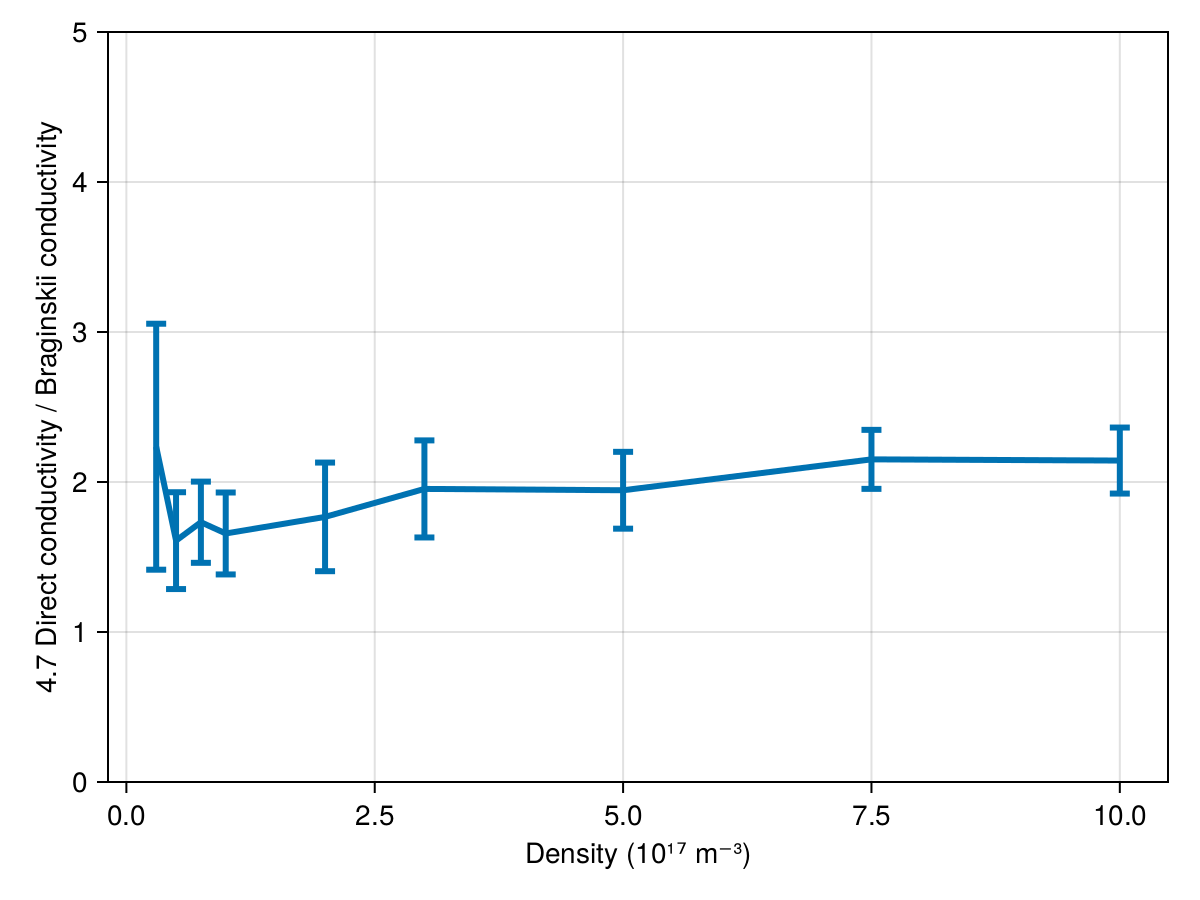

In [175]:
plot_vs_var(
    (:n, "Density (10¹⁷ m⁻³)", x -> x / 1e17),
    results[3:end], plot_ratio = true
)

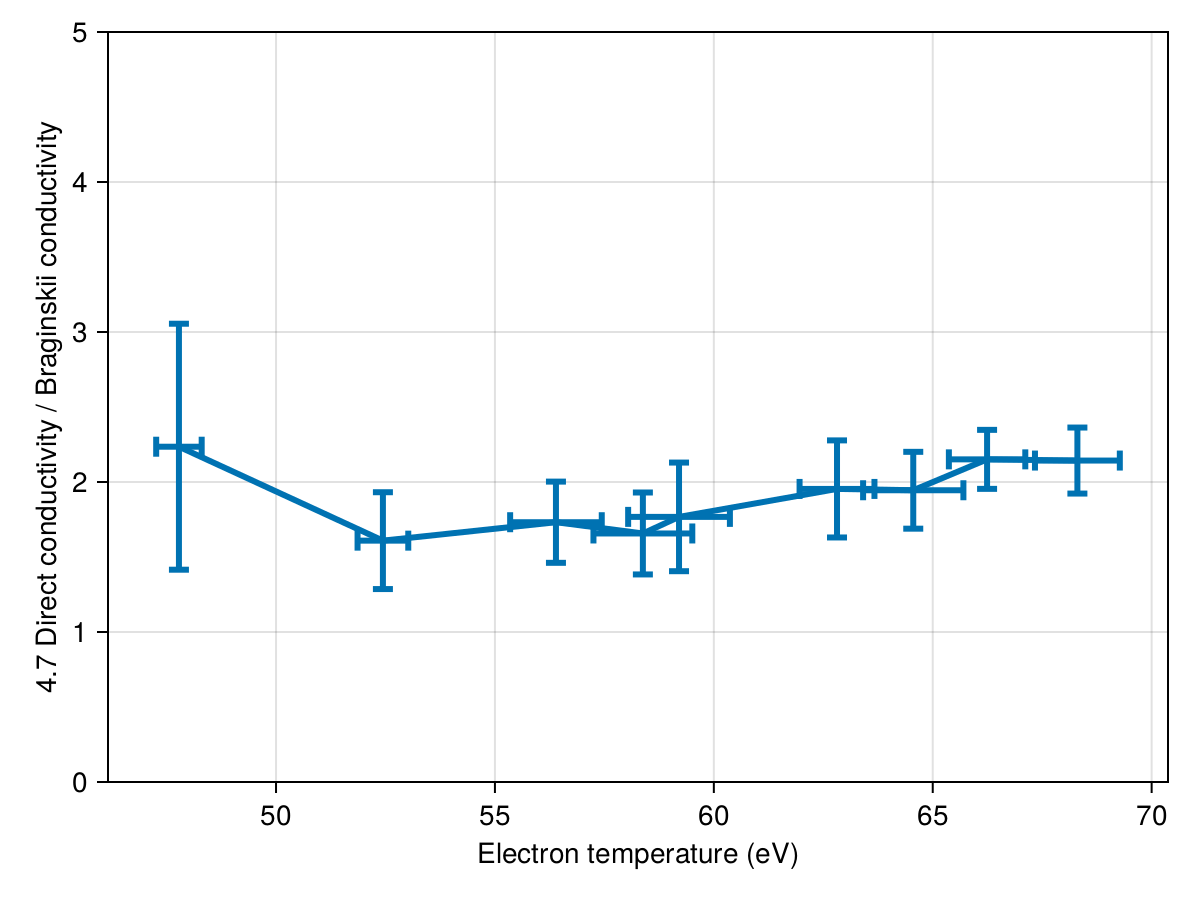

In [176]:
plot_vs_var(
    (:T, "Electron temperature (eV)", identity),
    results[3:end], plot_ratio = true
)

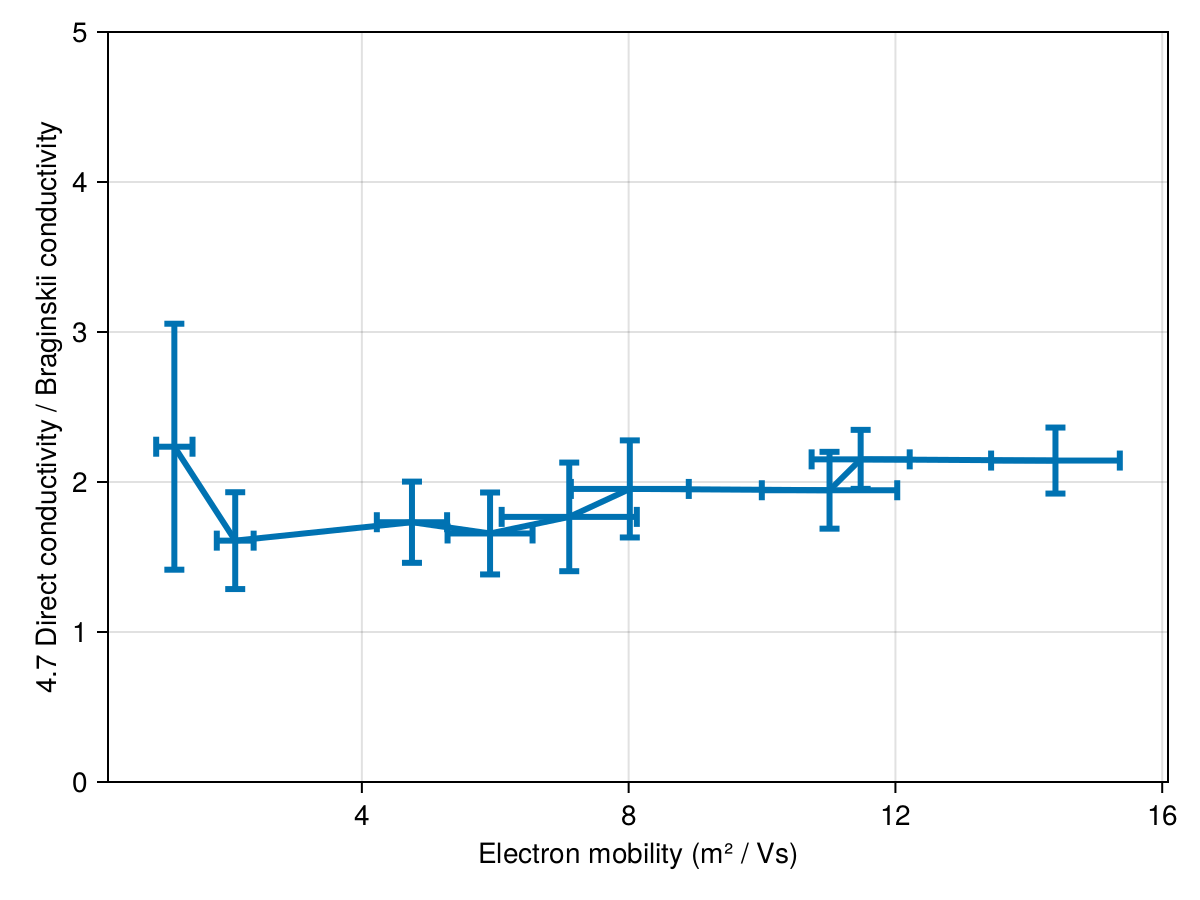

In [177]:
plot_vs_var(
    (:μ, "Electron mobility (m² / Vs)", identity),
    results[3:end], plot_ratio = true
)